# Tree partitioning

 In this section we discuss partitioning strategies for our computational domain that let us sort our sources and targets into admissible and non-admissible pairs.

Historically, Hierarchical Matrix methods use binary cluster trees to partition the computational domain, and Fast Multipole Methods use partitioning based on Octrees. In the following we will discuss both types of trees.

Before we talk about these two types of trees let us remind of the mathematical definition of a tree. We denote a graph as a tuple $G = (V, E)$, where $V$ is a set of vertices, and $E$ is a set of edges, connecting two vertices. We call a graph undirected if the edges have no orientation.

In this section we deal with a special type of undirected graph, namely a tree.

**Definition** A tree is an undirected graph $(G, E)$ in which any two vertices are connected by a unique simple path (in a simple path all vertices are distinct).

We designate one vertex in the tree as root. The parent of a vertex $v$ is the vertex directly connected to the root on the unique path to the root. The children of a verte $v$ are those vertices for which $v$ is a parent. We denote the set of children of $v$ by $\mathcal{C}(v)$.

We say that a vertex is a leaf if it has no children. We denote the set of leafs as $\mathcal{L}$.


The level $\ell(v)$ of a vertex $v$ is the number of edges on the direct path from $v$ to the root $r$. The root itself has level $0$, its children have level $1$. The depth of a tree is the maximum over all levels in the tree, that is $\text{depth} := \max_{v\in V}\ell(v)$.

For simplicity in this section we assume that we have $N$ points $x_i\in [0, 1]^d$, $i=1,\dots, N$, $d=2, 3$. By $J:=\{1, \dots, N\}$ we denote the corresponding index set.



## Cluster Trees



A cluster tree is a tree over the index set $J$ in which each vertex $v$ is associated with an index set $J_v\subset $J$ satisfying the following conditions.


- The index set of the root $r$ of the tree is $J$.
- For each vertex $v$ that is not a leaf the following two conditions hold
    - The index sets of the children of $v$ are disjoint, that is for $c, c'\in \mathcal{C}(v)$ and $c\neq c'$ we have that $J_c\cap J_{c'} = \emptyset$.
    - The union of the index sets of the children are identical to the index set of the parent, that is $J_v = \bigcup_{c\in\mathcal{C}(v)} J_c$.
- For each vertex $v$ that is not a leaf the number of children is larger than one, that is $|\mathcal{C}(v)| > 1$.
- No vertex is associated with the empty set, that is $|J_v| > 0$ for all $v\in V$.

In the following we implement simple data structures to construct a cluster tree. We have two classes, a bounding box class that stores geometric bounding boxes, and a Node class that stores an index set, allows subdivision and returns depth and leaf information.

The most important part is the subdivision. For subdivision we choose the dimension along which the bounding box is longest. We then compute the mean of the points in the index set along this dimension and separate the points by those who are smaller than the mean and those which are larger. From these we construct two new nodes.

There can be the pathological case that all points are aligned along aline. Then this strategy would leave one of the two new index sets empty. In that case we try to subdivide across the other dimension. If that fails as well we raise an exception since in that case all points in the index set are identical.

The recursive partitioning proceeds until the children have fewer than a given parameter ``nmin`` indices. This is chosen by the user and determines the depth of the tree.

In [1]:
class BoundingBox:
    """Store a bounding box for a two dimensionsal region."""

    def __init__(self, lower_left, upper_right):
        """Define a bounding box.
        
            lower_left and upper_right are tuples of floats that
            determine the lower left and upper right corner of the
            bounding box.       
        """

        self.lower_left = lower_left
        self.upper_right = upper_right

    def longest_dimension(self):
        """Return the longest dimension."""

        xlen = self.upper_right[0] - self.lower_left[0]
        ylen = self.upper_right[1] - self.lower_left[1]

        return 0 if xlen >= ylen else 1

    def subdivide(self, dim, separator):
        """Subdivide a bounding box along the given dimension.
        
            The parameter dim is either 0 (x-axis) or 1 (y-axis). The
            subdivision proceeds along this axis.

            The value separator specifies the point at which to divide up
            the bounding box.

        """

        if dim == 0:

            lower_left1 = self.lower_left
            upper_right1 = (separator, self.upper_right[1])

            lower_left2 = (separator, self.lower_left[1])
            upper_right2 = self.upper_right

        elif dim == 1:

            lower_left1 = self.lower_left
            upper_right1 = (self.upper_right[0], separator)

            lower_left2 = (self.lower_left[0], separator)
            upper_right2 = self.upper_right
        else:
            raise NotImplementedError

        return (BoundingBox(lower_left1, upper_right1), 
                BoundingBox(lower_left2, upper_right2))
            

In [22]:
class Node:
    """
    Stores information about nodes of a cluster tree and allows
    subdivision of a node.
    """

    def __init__(self, parent, indices, bounding_box, points):
        """
        Create a new node with given parent and indices.
        
        The bounding box has the form [(x_1, y_1), (x_2, y_2)]
        denoting the lower left and upper right point defining the
        bounding box for the index set.

        The variable points stores the original point set as Numpy
        array of shape (2, N).
        
        """

        self.parent = parent
        self.indices = indices
        self.children = None
        self.bounding_box = bounding_box
        self.points = points

    def subdivide(self):
        """Subdivide node along longest dimension."""

        dim = self.bounding_box.longest_dimension()

        first_set, second_set, separator = self.subdivide_impl(dim)

        if len(first_set) == 0 or len(second_set) == 0:
            # Subdivision along this axis did not work
            # Subdivide along the other axis

            dim = 1 - dim # Works since dim is either 0 or 1

            first_set, second_set, separator = self.subdivide_impl(dim)

            if len(first_set) == 0 or len(second_set) == 0:
                print(first_set)
                print(second_set)
                raise Exception("Subdivision not possible")

    
        bounding_box1, bounding_box2 = self.bounding_box.subdivide(dim, separator)

        node1 = Node(self, first_set, bounding_box1, points)
        node2 = Node(self, second_set, bounding_box2, points)

        return [node1, node2]

    def expand_to_tree(self, nmin):
        """Recursively subdivide until each index set of the descendents is smaller than nmin."""

        if len(self.indices) < nmin:
            return

        self.children = self.subdivide()
        self.children[0].expand_to_tree(nmin)
        self.children[1].expand_to_tree(nmin)

    def subdivide_impl(self, dim):
        """Implement the subdividison."""

        if len(self.indices) < 2:
            raise ValueError("No further subdivision possible.")

        median = np.median(self.points[dim, self.indices])

        first_set = self.indices[self.points[dim, self.indices] < median]
        second_set = self.indices[self.points[dim, self.indices] >= median]

        return (first_set, second_set, median)

    def leafs(self):
        """Return the leaf descendents of the node."""

        if self.children is None:
            return [self]
        else:
            return self.children[0].leafs() + self.children[1].leafs()

    def depth(self):
        """Return the depth of the tree from the current node."""

        if self.children is None:
            return 0
        else:
            return 1 + max(self.children[0].depth(), self.children[1].depth())
            




        

    

The following code presents a simple example of how to use the data structures.

In [25]:
import numpy as np

N = 500
nmin = 20

points = np.random.rand(2, N)
bounding_box = BoundingBox((0.0, 0.0), (1.0, 1.0))
root = Node([], np.arange(N), bounding_box, points)

root.expand_to_tree(nmin)
print(f"Depth: {root.depth()}")
print(f"Number of leafs: {len(root.leafs())}")

Depth: 5
Number of leafs: 32


In the following we discretise the unit circle, generate the corresponding cluster tree and draw the associated leaf boxes.

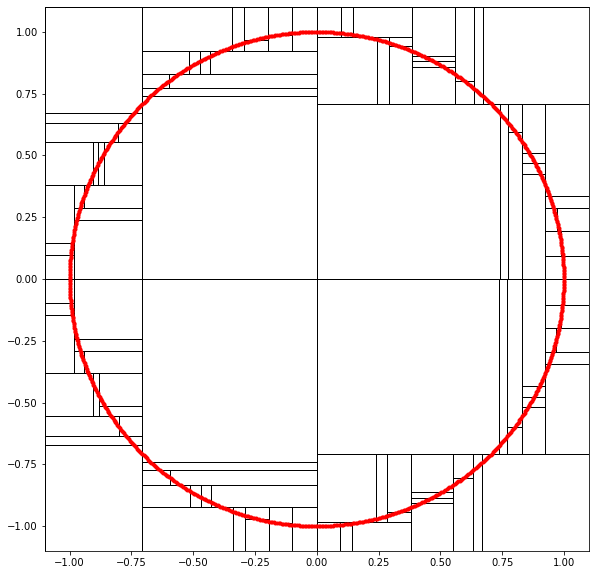

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline

N = 1001
nmin = 10

z = np.exp(1j * 2 * np.pi / N * np.arange(N))
points = np.array([np.real(z), np.imag(z)])
lower_left = (-1.1, -1.1)
upper_right = (1.1, 1.1)
bounding_box = BoundingBox(lower_left, upper_right)
root = Node([], np.arange(N), bounding_box, points)
root.expand_to_tree(nmin)

def node_to_patch(node):
    """Helper function that turns a node into a matplotlib rectangle patch."""
    from matplotlib.patches import Rectangle

    lower_left, upper_right = (node.bounding_box.lower_left, node.bounding_box.upper_right)

    origin = lower_left
    width = upper_right[0] - lower_left[0]
    height = upper_right[1] - lower_left[1]

    return Rectangle(origin, width, height, linewidth=1, edgecolor='k', fill=False)

leafs = root.leafs()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(lower_left[0], upper_right[0])
ax.set_ylim(lower_left[1], upper_right[1])

for leaf in leafs:
    ax.add_patch(
        node_to_patch(leaf)
    )

ax.plot(points[0, :], points[1, :], 'r.')






The figure demonstrates how the partitioning refines around the circle, attempting to keep similar numbers of points per box. Cluster trees are simple and as shown above, easy to implement. However, their non-uniform structure is not suitable for all types of applications. This is addressed by Octrees.

## Octrees

An octree (or quadtree in two dimensions) is a regular geometric partitioning. Instead of balancing the number of points per box an Octree/Quadtree subdivides a cube/square into 8/4 identically sized child cube/squares. The advantage is a uniform data structure. The boxes on a given level are all identical, making this structure ideal for methods that rely on this uniformity on each level.

We will not go into implementational details here. Even though Octrees/Quadtrees are simple in principle efficient indexing of them is an interesting problem that is solved by Morton encoding, which is based on Z-curve traversals of the tree. This topic leads very much into the realm of computer graphics and associated topics.